In [1]:
#python import statements

import numpy as np
import matplotlib.pyplot as plt
import cmath
import math
import random
import itertools
from scipy.optimize import minimize

In [2]:
#qiskit import statements

from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.quantum_info import random_statevector, Statevector
import qiskit.quantum_info as qi
from qiskit.circuit import Parameter #allows us to have parameterized gates
from qiskit.algorithms.optimizers import SPSA

# Use Aer's qasm_simulator
simulator = AerSimulator()

In [3]:
#helper function that takes in the angle as a parameter and returns the B matrix (B^dagger * B = P)
def add_proj_gate(phi, theta, cr):
    cr.rz(-1*phi, [0, 3])
    cr.ry(theta-math.pi, [0, 3])
    cr.rz(phi, [0, 3])

def add_proj_gate_conj(phi, theta, cr):
    cr.rz(-1*phi, [0, 3])
    cr.ry(math.pi-theta, [0, 3])
    cr.rz(phi, [0, 3])

In [4]:
def make_circuits(phi_1, phi_2, theta_1, theta_2, time):
    circuit = QuantumCircuit(6) #need 2N qubits in order to calculate the cost function at the end
    circuit.h([0, 3])
    circuit.rz(time, [0, 3]) #first time evolution
    add_proj_gate_conj(phi_1, theta_1, circuit)
    circuit.cx(0, 1)
    circuit.cx(3, 4)
    add_proj_gate(phi_1, theta_1, circuit)
    circuit.rz(time, [0,3]) #second time evolution
    add_proj_gate_conj(phi_2, theta_2, circuit)
    circuit.cx(0, 2)
    circuit.cx(3, 5)
    add_proj_gate(phi_2, theta_2, circuit)

    measPartial = QuantumCircuit(6, 2) #6 qubits, and 4 classical bits to record outcome
    measPartial.barrier(range(6)) #just draws a barrier on the circuit
    measPartial.cx(1, 4)
    measPartial.cx(2, 5)

    measPartial.measure([4, 5], range(2)) #add the two measurements

    #smooshing together the acutal circuit and the measurements on the end
    qcPartial = measPartial.compose(circuit, range(6), front=True)

    measFull = QuantumCircuit(6, 4) #6 qubits, and 4 classical bits to record outcome
    measFull.barrier(range(6)) #just draws a barrier on the circuit
    measFull.cx(1, 4)
    measFull.cx(2, 5)
    measFull.h([1, 2])
    #the hadamards are to calculate full cost

    measFull.measure([1, 2, 4, 5], range(4)) #add the four measurements
    #smooshing together the acutal circuit and the measurements on the end
    qcFull = measFull.compose(circuit, range(6), front=True)

    return(qcPartial, qcFull)

In [5]:
def bind_parameters(varying_params, qcFull, qcPartial):
    first_angle = varying_params[0][0]
    second_angle = varying_params[1][0]
    #first_range = varying_params[0][1]
    #second_range = varying_params[1][1]
    #angle_range = list(itertools.product(first_range, second_range))

    full_circuits = qcFull.assign_parameters({first_angle: first_angle_val, second_angle: second_angle_val})

    partial_circuits = qcPartial.assign_parameters({first_angle: first_angle_val, second_angle: second_angle_val})
            
    return(full_circuits, partial_circuits)

In [6]:
fails = {'0101', '0111', '1010', '1011', '1101', '1110'}
shots = 1024

#this needs to update, this now needs to be run for each element in counts_full and counts_partial which are each lists of count dictionaries

def compute_cost(full_counts, partial_counts):
    p_full = 0
    overlap_partial = 0
    for i in fails:
        if i in full_counts:
            p_full += full_counts[i]
    overlap_full = 1-2*(p_full/shots)
    overlap_partial = partial_counts['00']/shots
    return overlap_full-overlap_partial

In [7]:
def cost_function(var_array):
    #this first bit sets what the variable parameters are and sets the rest to the input values
    in_phi_1 = var_array[0]
    in_phi_2 = var_array[1]
    (phi_1, phi_2, theta_1, theta_2) = (in_phi_1, in_phi_2, 0.5*math.pi, 0.5*math.pi)
    time = 2
    varying_params = [phi_1, phi_2]
    #this is where we make the circuit
    qcPartial, qcFull = make_circuits(phi_1, phi_2, theta_1, theta_2, time)
    #bind parameters
    full_circuits = qcFull.assign_parameters({phi_1: in_phi_1, phi_2: in_phi_2})
    partial_circuits = qcPartial.assign_parameters({phi_1: in_phi_1, phi_2: in_phi_2})

    compiled_circuit_partial = transpile(partial_circuits, simulator)

    # Execute the circuit on the qasm simulator
    job_partial = simulator.run(compiled_circuit_partial, shots=1024)

    # Grab results from the job
    result_partial = job_partial.result()

    # Returns counts
    counts_partial = result_partial.get_counts()

    # compile the circuit down to low-level QASM instructions
    # supported by the backend (not needed for simple circuits)
    compiled_circuit_full = transpile(full_circuits, simulator)

    # Execute the circuit on the qasm simulator
    job_full = simulator.run(compiled_circuit_full, shots=1024)

    # Grab results from the job
    result_full = job_full.result()

    # Returns counts
    counts_full = result_full.get_counts()

    cost = compute_cost(counts_full, counts_partial)
    return cost

In [8]:
def visualize_cost(cost_matrix, varying_params):
    first_angle = varying_params[0][0]
    second_angle = varying_params[1][0]
    first_range = varying_params[0][1]
    second_range = varying_params[1][1]
    plt.imshow(cost_matrix, cmap='hot', interpolation='none', extent=[min(first_range), max(first_range), min(second_range), max(second_range)], vmin=0, vmax=0.4)
    plt.xlabel(first_angle)
    plt.ylabel(second_angle)
    plt.colorbar()
    plt.show() 

In [18]:
initial_guess = np.array([0,1])
result = minimize(cost_function, initial_guess, method='COBYLA')
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.0302734375
       x: [ 2.448e-04  1.984e+00]
    nfev: 27
   maxcv: 0.0


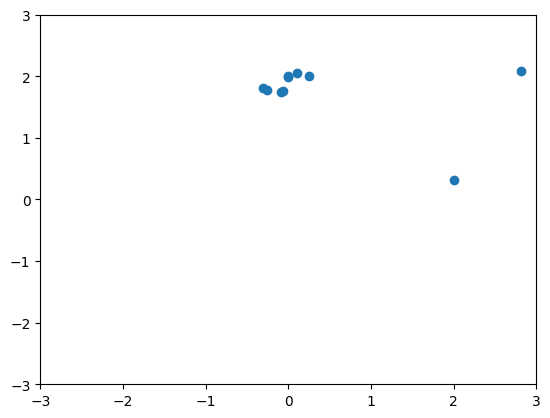

In [19]:
points = ([-6.404e-02, 1.758e+00], [-8.180e-02, 1.748e+00], [-3.103e-01, 1.816e+00], [-9.638e-05, 2.000e+00], [ 2.812e+00, 2.091e+00],
[ 1.108e-01, 2.059e+00], [ 2.004e+00, 3.099e-01], [-2.603e-01, 1.772e+00], [ 2.518e-01, 2.004e+00], [ 2.448e-04, 1.984e+00])
x,y = list(zip(*points))
plt.scatter(x, y)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()
#initial guess of (0,1)

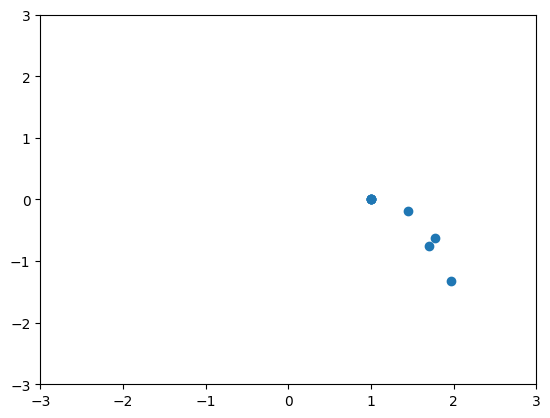

In [51]:
points = ([1.775e+00, -6.326e-01], [1.450e+00, -1.919e-01], [ 1.703e+00, -7.542e-01], [ 9.999e-01, -5.048e-05], [ 1.974e+00, -1.321e+00], [ 9.969e-01,  2.504e-03], [ 1.007e+00,  3.208e-03], [ 9.999e-01,  8.951e-06], [ 1.000e+00,  9.751e-05])
x,y = list(zip(*points))
plt.scatter(x, y)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()
#initial guess of (0,0)

In [36]:
points = [0]*10
i = 0
for i in range(10):
    initial_guess = np.array([random.uniform(-3, 3),random.uniform(-3, 3)])
    spsa = SPSA(maxiter=300)
    result = spsa.minimize(cost_function, initial_guess)
    points[i]=result.x.tolist()
    print(result.x)
    i+=1
print(points)

#TODO: this kinda works, but just need to wrap the results back around to (-pi, pi). There has to be some way of doing it but right now is not that time

[1.85507132 1.39412135]
[-1.19110133  6.65316446]
[-4.24717843  1.11747527]
[ 2.02744925 -2.16467063]
[ 1.93026346 -2.44547932]
[-1.69988847  3.29195788]
[-3.19562639 -1.16126501]
[-1.12898761 -0.85629287]
[ 0.35941468 -3.89050716]
[-1.0911385 -2.3602476]
[[1.8550713166634822, 1.3941213479612562], [-1.1911013318899966, 6.653164457478317], [-4.247178433757171, 1.1174752650170015], [2.0274492470247454, -2.1646706315343236], [1.9302634636873193, -2.445479318904044], [-1.6998884677725465, 3.2919578767695756], [-3.195626388783025, -1.1612650133593876], [-1.1289876128406364, -0.8562928732607351], [0.35941467545908656, -3.8905071630942194], [-1.091138503277278, -2.360247597250698]]


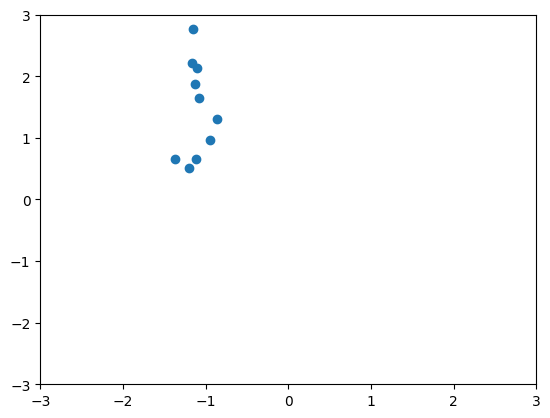

In [24]:
points = ([-0.9456656265043037, 0.9594364726969045], [-1.0806806312531076, 1.6441104392065635], [-1.195564081027643, 0.5099114993620453], [-1.1310785198829698, 1.874743787227125], [-1.1091504782325428, 2.1424524993555303], [-1.1636452219761528, 2.2228740343871944], [-1.3691674289567415, 0.6537936873847714], [-1.150661782122826, 2.7686577530163023], [-0.857400622814299, 1.3047195577726909], [-1.119173352764203, 0.6607009190081586])
x,y = list(zip(*points))
plt.scatter(x, y)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()
#initial guess of [0, 1]

In [34]:
import random
a = random.uniform(-3, 3)
print(a)

-1.0039713570878106


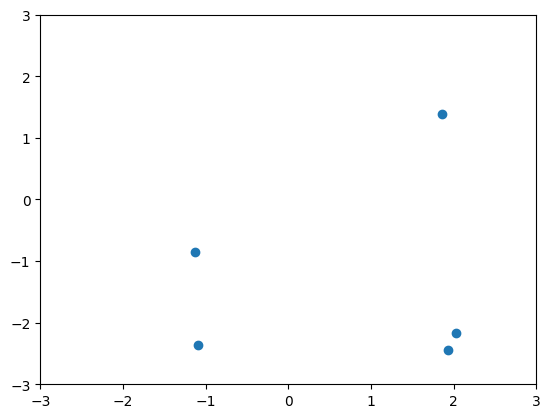

In [37]:
points = ([1.8550713166634822, 1.3941213479612562], [-1.1911013318899966, 6.653164457478317], [-4.247178433757171, 1.1174752650170015], [2.0274492470247454, -2.1646706315343236], [1.9302634636873193, -2.445479318904044], [-1.6998884677725465, 3.2919578767695756], [-3.195626388783025, -1.1612650133593876], [-1.1289876128406364, -0.8562928732607351], [0.35941467545908656, -3.8905071630942194], [-1.091138503277278, -2.360247597250698])
x,y = list(zip(*points))
plt.scatter(x, y)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()